# Estimating the Radial Velocity Uncertainty
Following [cite](url), I will cross-correlate model spectra against themselves to estimate how well I can measure the primary star radial velocity shift as a function of temperature and vsini. I will use the following grid:

 - Teff: 7000-10000 in 1000 K steps, 10000-30000 K in 2000 K steps
 - logg: 3.5, 4.0
 - [Fe/H]: -0.5, 0.0, +0.5
 - vsini: 50 - 300 km/s in 25 km/s steps
 
That works out to 840 grid points. At each point, I will randomly sample 10 RVs from N(0, 30), and try each one. Additionally, I will do this whole process for each instrument so that I include the actual wavelengths used in the primary star rv fits. This will probably take a few days at least...

## Update:

After testing, it looks like log(g) and [Fe/H] have basically no impact. So, I will use only $log(g) = 4.0$ and [Fe/H] $=0.0$

In [3]:
import StellarModel
import HelperFunctions
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as interp
from telfit import DataStructures, FittingUtilities
import GenericSearch
import matplotlib.pyplot as plt
import plottools
from astropy import units as u, constants
import logging
import Correlate
import h5py
import Broaden
import seaborn as sns
from collections import defaultdict
import pandas as pd

%matplotlib inline
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [41]:
ls *.csv

CCF_Error_Simulation_CHIRON_backup.csv  CCF_Error_Simulation_HRS.csv
CCF_Error_Simulation_CHIRON.csv         CCF_Error_Simulation_TS23.csv


In [42]:
# Instrument-specific parameters!
hdf5_file = '/media/ExtraSpace/Kurucz_FullGrid/IGRINS_grid_air.hdf5'
hdf5_group = 'IGRINS'
data_file = '/home/kgullikson/School/Research/IGRINS_data/20150726/HIP_100221_telluric_corrected_renormalized.fits'
output_file = '/home/kgullikson/School/Research/BinaryInference/RVError.h5'
output_summary_file = '/home/kgullikson/School/Research/BinaryInference/CCF_Error_Simulation_IGRINS.csv'
#badregions = [[475, 495]]
badregions=[]
resolution = 45000
trimsize=10

# General parameters
Tvalues = range(7000, 10000, 1000) + range(10000, 30001, 2000)
metal_values = (0.0,)
logg_values = (4.0,)
vsini_values = range(50, 301, 25)
N_trials=50
rv_dispersion = 30
snr = 300.0  # Signal-to-noise ratio
addmode = 'all'
c = constants.c.to(u.km/u.s).value

In [43]:
# Find the appropriate models
model_list = StellarModel.GetModelList(type='hdf5',
                                           hdf5_file=hdf5_file,
                                           temperature=Tvalues,
                                           metal=metal_values,
                                           logg=logg_values)
modeldict, processed = StellarModel.MakeModelDicts(model_list, type='hdf5', hdf5_file=hdf5_file,
                                                       vsini_values=vsini_values, vac2air=True, logspace=True)

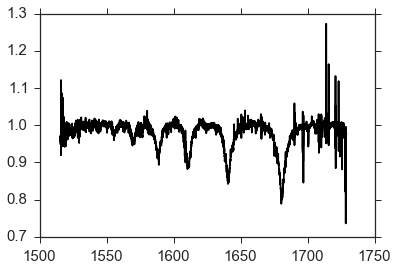

In [44]:
# Read in a data spectrum (used for the wavelengths only)
processed_orders = GenericSearch.Process_Data(data_file, badregions=badregions, trimsize=trimsize, 
                                              logspacing=True, reject_outliers=False)
for order in processed_orders:
    plt.plot(order.x, order.y, 'k-')

low_wave = processed_orders[0].x[0]
high_wave = processed_orders[-1].x[-1]
Npix = np.sum([o.size() for o in processed_orders])

In [45]:
def check_rv(corr, params, hdf5_output, n_pixels=None):
    if params['addmode'].lower() == 'all':
        for am in corr.keys():
            p = params
            p['addmode'] = am
            check_rv(corr[am], p, hdf5_output, n_pixels=n_pixels)
        return
    
    # Create new dataset in hdf5 output file
    f = h5py.File(hdf5_output, 'a')
    grp = f.require_group('{group:s}/addmode-{addmode}/T{teff:.0f}/logg{logg:.1f}/feh{feh:+.1f}/vsini{vsini:.0f}'.format(**params))
    ds_name = 'ds{}'.format(len(grp.keys())+1)
    ds = grp.create_dataset(ds_name, data=np.array((corr.x, corr.y)), maxshape=(2, None))
    logging.debug('Generating dataset with name {}'.format(ds.name))
    
    # Add attributes
    ds.attrs['teff'] = params['teff']
    ds.attrs['logg'] = params['logg']
    ds.attrs['feh'] = params['feh']
    ds.attrs['vsini'] = params['vsini']
    ds.attrs['true_rv'] = params['velocity']
    ds.attrs['addmode'] = params['addmode']
    rv, rv_err, ccf_val = Correlate.get_rv(corr.x, corr.y, Npix=n_pixels)
    ds.attrs['vel_max'] = rv
    ds.attrs['vel_max_err'] = rv_err
    ds.attrs['ccf_max'] = ccf_val
    logging.debug('True rv = {:.4f}\tMeasured rv = {:.4f} +/- {:.5f}'.format(params['velocity'], rv, rv_err))
    
    f.flush()
    f.close()
    

In [46]:
alpha = 0.0
for temp in sorted(modeldict.keys()):
    for gravity in sorted(modeldict[temp].keys()):
        for metallicity in sorted(modeldict[temp][gravity].keys()):
            for vsini in vsini_values:
                logging.info('\nT: {}, logg: {}, [Fe/H]: {}, vsini: {}'.format(temp, gravity, metallicity, vsini))
                
                # Broaden the model near the wavelengths I will use
                model = modeldict[temp][gravity][metallicity][alpha][vsini]
                left = np.searchsorted(model.x, low_wave-15)
                right = np.searchsorted(model.x, high_wave+15)
                model = Broaden.RotBroad(model[left:right], vsini * u.km.to(u.cm), linear=True)
                if resolution is not None:
                    model = FittingUtilities.ReduceResolutionFFT(model, resolution)

                # Make an interpolator function
                modelfcn = interp(model.x, model.y / model.cont)
                
                # Make model orders at 0 km/2
                model_orders = GenericSearch.process_model(model.copy(), processed_orders, logspace=False)
                
                for rv in np.random.normal(loc=0, scale=rv_dispersion, size=N_trials):
                    # Make orders.
                    orders = [o.copy() for o in processed_orders]
                    for i, order in enumerate(orders):
                        order.y = modelfcn(order.x*(1-rv/c)) + np.random.normal(loc=0, scale=1.0/snr, size=order.size())
                        order.cont = np.ones_like(order.x)
                        orders[i] = order.copy()
                    
                    # cross-correlate
                    corr = Correlate.Correlate(orders, model_orders, addmode=addmode)
                    
                    params = {'velocity': rv, 'teff': temp, 'vsini': vsini, 'group': hdf5_group,
                              'logg': gravity, 'feh': metallicity, 'addmode': addmode}
                    check_rv(corr, params, output_file, n_pixels=Npix)
                

INFO:root:
T: 7000, logg: 4.0, [Fe/H]: 0.0, vsini: 50
INFO:root:
T: 7000, logg: 4.0, [Fe/H]: 0.0, vsini: 75


INFO:root:
T: 7000, logg: 4.0, [Fe/H]: 0.0, vsini: 100


INFO:root:
T: 7000, logg: 4.0, [Fe/H]: 0.0, vsini: 125


INFO:root:
T: 7000, logg: 4.0, [Fe/H]: 0.0, vsini: 150


INFO:root:
T: 7000, logg: 4.0, [Fe/H]: 0.0, vsini: 175


INFO:root:
T: 7000, logg: 4.0, [Fe/H]: 0.0, vsini: 200


INFO:root:
T: 7000, logg: 4.0, [Fe/H]: 0.0, vsini: 225


INFO:root:
T: 7000, logg: 4.0, [Fe/H]: 0.0, vsini: 250


INFO:root:
T: 7000, logg: 4.0, [Fe/H]: 0.0, vsini: 275


INFO:root:
T: 7000, logg: 4.0, [Fe/H]: 0.0, vsini: 300


INFO:root:
T: 8000, logg: 4.0, [Fe/H]: 0.0, vsini: 50


INFO:root:
T: 8000, logg: 4.0, [Fe/H]: 0.0, vsini: 75


INFO:root:
T: 8000, logg: 4.0, [Fe/H]: 0.0, vsini: 100


INFO:root:
T: 8000, logg: 4.0, [Fe/H]: 0.0, vsini: 125


INFO:root:
T: 8000, logg: 4.0, [Fe/H]: 0.0, vsini: 150


INFO:root:
T: 8000, logg: 4.0, [Fe/H]: 0.0, vsini: 175


INFO:root:
T: 8000, logg: 4.0, [Fe/H]: 0.0, vsini: 200


INFO:root:
T: 8000, logg: 4.0, [Fe/H]: 0.0, vsini: 225


INFO:root:
T: 8000, logg: 4.0, [Fe/H]: 0.0, vsini: 250


INFO:root:
T: 8000, logg: 4.0, [Fe/H]: 0.0, vsini: 275


INFO:root:
T: 8000, logg: 4.0, [Fe/H]: 0.0, vsini: 300


INFO:root:
T: 9000, logg: 4.0, [Fe/H]: 0.0, vsini: 50


INFO:root:
T: 9000, logg: 4.0, [Fe/H]: 0.0, vsini: 75


INFO:root:
T: 9000, logg: 4.0, [Fe/H]: 0.0, vsini: 100


INFO:root:
T: 9000, logg: 4.0, [Fe/H]: 0.0, vsini: 125


INFO:root:
T: 9000, logg: 4.0, [Fe/H]: 0.0, vsini: 150


INFO:root:
T: 9000, logg: 4.0, [Fe/H]: 0.0, vsini: 175


INFO:root:
T: 9000, logg: 4.0, [Fe/H]: 0.0, vsini: 200


INFO:root:
T: 9000, logg: 4.0, [Fe/H]: 0.0, vsini: 225


INFO:root:
T: 9000, logg: 4.0, [Fe/H]: 0.0, vsini: 250


INFO:root:
T: 9000, logg: 4.0, [Fe/H]: 0.0, vsini: 275


INFO:root:
T: 9000, logg: 4.0, [Fe/H]: 0.0, vsini: 300


INFO:root:
T: 10000, logg: 4.0, [Fe/H]: 0.0, vsini: 50


INFO:root:
T: 10000, logg: 4.0, [Fe/H]: 0.0, vsini: 75


INFO:root:
T: 10000, logg: 4.0, [Fe/H]: 0.0, vsini: 100


INFO:root:
T: 10000, logg: 4.0, [Fe/H]: 0.0, vsini: 125


INFO:root:
T: 10000, logg: 4.0, [Fe/H]: 0.0, vsini: 150


INFO:root:
T: 10000, logg: 4.0, [Fe/H]: 0.0, vsini: 175


INFO:root:
T: 10000, logg: 4.0, [Fe/H]: 0.0, vsini: 200


INFO:root:
T: 10000, logg: 4.0, [Fe/H]: 0.0, vsini: 225


INFO:root:
T: 10000, logg: 4.0, [Fe/H]: 0.0, vsini: 250


INFO:root:
T: 10000, logg: 4.0, [Fe/H]: 0.0, vsini: 275


INFO:root:
T: 10000, logg: 4.0, [Fe/H]: 0.0, vsini: 300


INFO:root:
T: 12000, logg: 4.0, [Fe/H]: 0.0, vsini: 50


INFO:root:
T: 12000, logg: 4.0, [Fe/H]: 0.0, vsini: 75


INFO:root:
T: 12000, logg: 4.0, [Fe/H]: 0.0, vsini: 100


INFO:root:
T: 12000, logg: 4.0, [Fe/H]: 0.0, vsini: 125


INFO:root:
T: 12000, logg: 4.0, [Fe/H]: 0.0, vsini: 150


INFO:root:
T: 12000, logg: 4.0, [Fe/H]: 0.0, vsini: 175


INFO:root:
T: 12000, logg: 4.0, [Fe/H]: 0.0, vsini: 200


INFO:root:
T: 12000, logg: 4.0, [Fe/H]: 0.0, vsini: 225


INFO:root:
T: 12000, logg: 4.0, [Fe/H]: 0.0, vsini: 250


INFO:root:
T: 12000, logg: 4.0, [Fe/H]: 0.0, vsini: 275


INFO:root:
T: 12000, logg: 4.0, [Fe/H]: 0.0, vsini: 300


INFO:root:
T: 14000, logg: 4.0, [Fe/H]: 0.0, vsini: 50


INFO:root:
T: 14000, logg: 4.0, [Fe/H]: 0.0, vsini: 75


INFO:root:
T: 14000, logg: 4.0, [Fe/H]: 0.0, vsini: 100


INFO:root:
T: 14000, logg: 4.0, [Fe/H]: 0.0, vsini: 125


INFO:root:
T: 14000, logg: 4.0, [Fe/H]: 0.0, vsini: 150


INFO:root:
T: 14000, logg: 4.0, [Fe/H]: 0.0, vsini: 175


INFO:root:
T: 14000, logg: 4.0, [Fe/H]: 0.0, vsini: 200


INFO:root:
T: 14000, logg: 4.0, [Fe/H]: 0.0, vsini: 225


INFO:root:
T: 14000, logg: 4.0, [Fe/H]: 0.0, vsini: 250


INFO:root:
T: 14000, logg: 4.0, [Fe/H]: 0.0, vsini: 275


INFO:root:
T: 14000, logg: 4.0, [Fe/H]: 0.0, vsini: 300


INFO:root:
T: 16000, logg: 4.0, [Fe/H]: 0.0, vsini: 50


INFO:root:
T: 16000, logg: 4.0, [Fe/H]: 0.0, vsini: 75


INFO:root:
T: 16000, logg: 4.0, [Fe/H]: 0.0, vsini: 100


INFO:root:
T: 16000, logg: 4.0, [Fe/H]: 0.0, vsini: 125


INFO:root:
T: 16000, logg: 4.0, [Fe/H]: 0.0, vsini: 150


INFO:root:
T: 16000, logg: 4.0, [Fe/H]: 0.0, vsini: 175


INFO:root:
T: 16000, logg: 4.0, [Fe/H]: 0.0, vsini: 200


INFO:root:
T: 16000, logg: 4.0, [Fe/H]: 0.0, vsini: 225


INFO:root:
T: 16000, logg: 4.0, [Fe/H]: 0.0, vsini: 250


INFO:root:
T: 16000, logg: 4.0, [Fe/H]: 0.0, vsini: 275


INFO:root:
T: 16000, logg: 4.0, [Fe/H]: 0.0, vsini: 300


INFO:root:
T: 18000, logg: 4.0, [Fe/H]: 0.0, vsini: 50


INFO:root:
T: 18000, logg: 4.0, [Fe/H]: 0.0, vsini: 75


INFO:root:
T: 18000, logg: 4.0, [Fe/H]: 0.0, vsini: 100


INFO:root:
T: 18000, logg: 4.0, [Fe/H]: 0.0, vsini: 125


INFO:root:
T: 18000, logg: 4.0, [Fe/H]: 0.0, vsini: 150


INFO:root:
T: 18000, logg: 4.0, [Fe/H]: 0.0, vsini: 175


INFO:root:
T: 18000, logg: 4.0, [Fe/H]: 0.0, vsini: 200


INFO:root:
T: 18000, logg: 4.0, [Fe/H]: 0.0, vsini: 225


INFO:root:
T: 18000, logg: 4.0, [Fe/H]: 0.0, vsini: 250


INFO:root:
T: 18000, logg: 4.0, [Fe/H]: 0.0, vsini: 275


INFO:root:
T: 18000, logg: 4.0, [Fe/H]: 0.0, vsini: 300


INFO:root:
T: 20000, logg: 4.0, [Fe/H]: 0.0, vsini: 50


INFO:root:
T: 20000, logg: 4.0, [Fe/H]: 0.0, vsini: 75


INFO:root:
T: 20000, logg: 4.0, [Fe/H]: 0.0, vsini: 100


INFO:root:
T: 20000, logg: 4.0, [Fe/H]: 0.0, vsini: 125


INFO:root:
T: 20000, logg: 4.0, [Fe/H]: 0.0, vsini: 150


INFO:root:
T: 20000, logg: 4.0, [Fe/H]: 0.0, vsini: 175


INFO:root:
T: 20000, logg: 4.0, [Fe/H]: 0.0, vsini: 200


INFO:root:
T: 20000, logg: 4.0, [Fe/H]: 0.0, vsini: 225


INFO:root:
T: 20000, logg: 4.0, [Fe/H]: 0.0, vsini: 250


INFO:root:
T: 20000, logg: 4.0, [Fe/H]: 0.0, vsini: 275


INFO:root:
T: 20000, logg: 4.0, [Fe/H]: 0.0, vsini: 300


INFO:root:
T: 22000, logg: 4.0, [Fe/H]: 0.0, vsini: 50


INFO:root:
T: 22000, logg: 4.0, [Fe/H]: 0.0, vsini: 75


INFO:root:
T: 22000, logg: 4.0, [Fe/H]: 0.0, vsini: 100


INFO:root:
T: 22000, logg: 4.0, [Fe/H]: 0.0, vsini: 125


INFO:root:
T: 22000, logg: 4.0, [Fe/H]: 0.0, vsini: 150


INFO:root:
T: 22000, logg: 4.0, [Fe/H]: 0.0, vsini: 175


INFO:root:
T: 22000, logg: 4.0, [Fe/H]: 0.0, vsini: 200


INFO:root:
T: 22000, logg: 4.0, [Fe/H]: 0.0, vsini: 225


INFO:root:
T: 22000, logg: 4.0, [Fe/H]: 0.0, vsini: 250


INFO:root:
T: 22000, logg: 4.0, [Fe/H]: 0.0, vsini: 275


INFO:root:
T: 22000, logg: 4.0, [Fe/H]: 0.0, vsini: 300


INFO:root:
T: 24000, logg: 4.0, [Fe/H]: 0.0, vsini: 50


INFO:root:
T: 24000, logg: 4.0, [Fe/H]: 0.0, vsini: 75


INFO:root:
T: 24000, logg: 4.0, [Fe/H]: 0.0, vsini: 100


INFO:root:
T: 24000, logg: 4.0, [Fe/H]: 0.0, vsini: 125


INFO:root:
T: 24000, logg: 4.0, [Fe/H]: 0.0, vsini: 150


INFO:root:
T: 24000, logg: 4.0, [Fe/H]: 0.0, vsini: 175


INFO:root:
T: 24000, logg: 4.0, [Fe/H]: 0.0, vsini: 200


INFO:root:
T: 24000, logg: 4.0, [Fe/H]: 0.0, vsini: 225


INFO:root:
T: 24000, logg: 4.0, [Fe/H]: 0.0, vsini: 250


INFO:root:
T: 24000, logg: 4.0, [Fe/H]: 0.0, vsini: 275


INFO:root:
T: 24000, logg: 4.0, [Fe/H]: 0.0, vsini: 300


INFO:root:
T: 26000, logg: 4.0, [Fe/H]: 0.0, vsini: 50


INFO:root:
T: 26000, logg: 4.0, [Fe/H]: 0.0, vsini: 75


INFO:root:
T: 26000, logg: 4.0, [Fe/H]: 0.0, vsini: 100


INFO:root:
T: 26000, logg: 4.0, [Fe/H]: 0.0, vsini: 125


INFO:root:
T: 26000, logg: 4.0, [Fe/H]: 0.0, vsini: 150


INFO:root:
T: 26000, logg: 4.0, [Fe/H]: 0.0, vsini: 175


INFO:root:
T: 26000, logg: 4.0, [Fe/H]: 0.0, vsini: 200


INFO:root:
T: 26000, logg: 4.0, [Fe/H]: 0.0, vsini: 225


INFO:root:
T: 26000, logg: 4.0, [Fe/H]: 0.0, vsini: 250


INFO:root:
T: 26000, logg: 4.0, [Fe/H]: 0.0, vsini: 275


INFO:root:
T: 26000, logg: 4.0, [Fe/H]: 0.0, vsini: 300


INFO:root:
T: 28000, logg: 4.0, [Fe/H]: 0.0, vsini: 50


INFO:root:
T: 28000, logg: 4.0, [Fe/H]: 0.0, vsini: 75


INFO:root:
T: 28000, logg: 4.0, [Fe/H]: 0.0, vsini: 100


INFO:root:
T: 28000, logg: 4.0, [Fe/H]: 0.0, vsini: 125


INFO:root:
T: 28000, logg: 4.0, [Fe/H]: 0.0, vsini: 150


INFO:root:
T: 28000, logg: 4.0, [Fe/H]: 0.0, vsini: 175


INFO:root:
T: 28000, logg: 4.0, [Fe/H]: 0.0, vsini: 200


INFO:root:
T: 28000, logg: 4.0, [Fe/H]: 0.0, vsini: 225


INFO:root:
T: 28000, logg: 4.0, [Fe/H]: 0.0, vsini: 250


INFO:root:
T: 28000, logg: 4.0, [Fe/H]: 0.0, vsini: 275


INFO:root:
T: 28000, logg: 4.0, [Fe/H]: 0.0, vsini: 300


INFO:root:
T: 30000, logg: 4.0, [Fe/H]: 0.0, vsini: 50


INFO:root:
T: 30000, logg: 4.0, [Fe/H]: 0.0, vsini: 75


INFO:root:
T: 30000, logg: 4.0, [Fe/H]: 0.0, vsini: 100


INFO:root:
T: 30000, logg: 4.0, [Fe/H]: 0.0, vsini: 125


INFO:root:
T: 30000, logg: 4.0, [Fe/H]: 0.0, vsini: 150


INFO:root:
T: 30000, logg: 4.0, [Fe/H]: 0.0, vsini: 175


INFO:root:
T: 30000, logg: 4.0, [Fe/H]: 0.0, vsini: 200


INFO:root:
T: 30000, logg: 4.0, [Fe/H]: 0.0, vsini: 225


INFO:root:
T: 30000, logg: 4.0, [Fe/H]: 0.0, vsini: 250


INFO:root:
T: 30000, logg: 4.0, [Fe/H]: 0.0, vsini: 275


INFO:root:
T: 30000, logg: 4.0, [Fe/H]: 0.0, vsini: 300


In [47]:
dd = defaultdict(list)
with h5py.File('RVError.h5', 'r') as f:
    for addmode_str, am_grp in f[hdf5_group].iteritems():
        for _, teff_grp in am_grp.iteritems():
            print(teff_grp.name)
            for _, logg_grp in teff_grp.iteritems():
                for _, feh_grp in logg_grp.iteritems():
                    for _, vsini_grp in feh_grp.iteritems():
                        for _, dataset in vsini_grp.iteritems():
                            dd['addmode'].append(dataset.attrs['addmode'])
                            #dd['addmode'].append(addmode_str.split('-')[-1])
                            dd['teff'].append(dataset.attrs['teff'])
                            dd['logg'].append(dataset.attrs['logg'])
                            dd['feh'].append(dataset.attrs['feh'])
                            dd['vsini'].append(dataset.attrs['vsini'])
                            dd['rv_err'].append(dataset.attrs['true_rv'] - dataset.attrs['vel_max'])
                            dd['formal_rv_err'].append(dataset.attrs['vel_max_err'])
                            dd['ccf'].append(dataset.attrs['ccf_max'])
                            
summary = pd.DataFrame(data=dd)
summary.head()

/IGRINS/addmode-dc/T10000
/IGRINS/addmode-dc/T12000
/IGRINS/addmode-dc/T14000
/IGRINS/addmode-dc/T16000
/IGRINS/addmode-dc/T18000
/IGRINS/addmode-dc/T20000
/IGRINS/addmode-dc/T22000
/IGRINS/addmode-dc/T24000
/IGRINS/addmode-dc/T26000
/IGRINS/addmode-dc/T28000
/IGRINS/addmode-dc/T30000
/IGRINS/addmode-dc/T7000
/IGRINS/addmode-dc/T8000
/IGRINS/addmode-dc/T9000
/IGRINS/addmode-ml/T10000
/IGRINS/addmode-ml/T12000
/IGRINS/addmode-ml/T14000
/IGRINS/addmode-ml/T16000
/IGRINS/addmode-ml/T18000
/IGRINS/addmode-ml/T20000
/IGRINS/addmode-ml/T22000
/IGRINS/addmode-ml/T24000
/IGRINS/addmode-ml/T26000
/IGRINS/addmode-ml/T28000
/IGRINS/addmode-ml/T30000
/IGRINS/addmode-ml/T7000
/IGRINS/addmode-ml/T8000
/IGRINS/addmode-ml/T9000
/IGRINS/addmode-simple/T10000
/IGRINS/addmode-simple/T12000
/IGRINS/addmode-simple/T14000
/IGRINS/addmode-simple/T16000
/IGRINS/addmode-simple/T18000
/IGRINS/addmode-simple/T20000
/IGRINS/addmode-simple/T22000
/IGRINS/addmode-simple/T24000
/IGRINS/addmode-simple/T26000
/IGRINS/

,addmode,ccf,feh,formal_rv_err,logg,rv_err,teff,vsini
0,dc,0.868330,0,1.010518,4,-1.154569,10000,100
1,dc,0.867952,0,1.018585,4,-4.682545,10000,100
2,dc,0.863125,0,1.118071,4,-0.744341,10000,100
3,dc,0.866247,0,1.064088,4,-1.508000,10000,100
4,dc,0.866849,0,1.179235,4,-3.641454,10000,100


In [48]:
funcs = [np.mean, np.std]
error = summary.groupby(('teff', 'vsini', 'addmode'))['rv_err'].agg(dict(rms=lambda d: np.sqrt(np.sum(d**2)/(len(d)-1.0))))

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


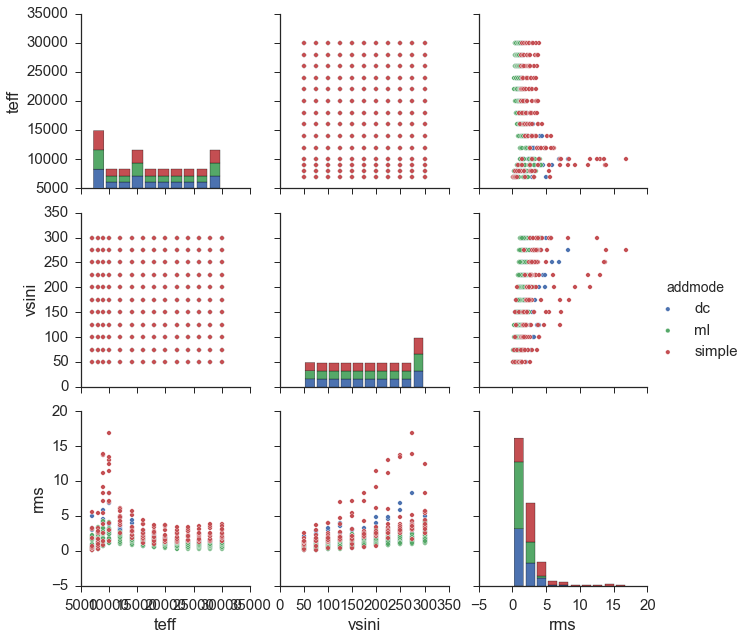

In [51]:
sns.pairplot(error.reset_index(), hue='addmode')

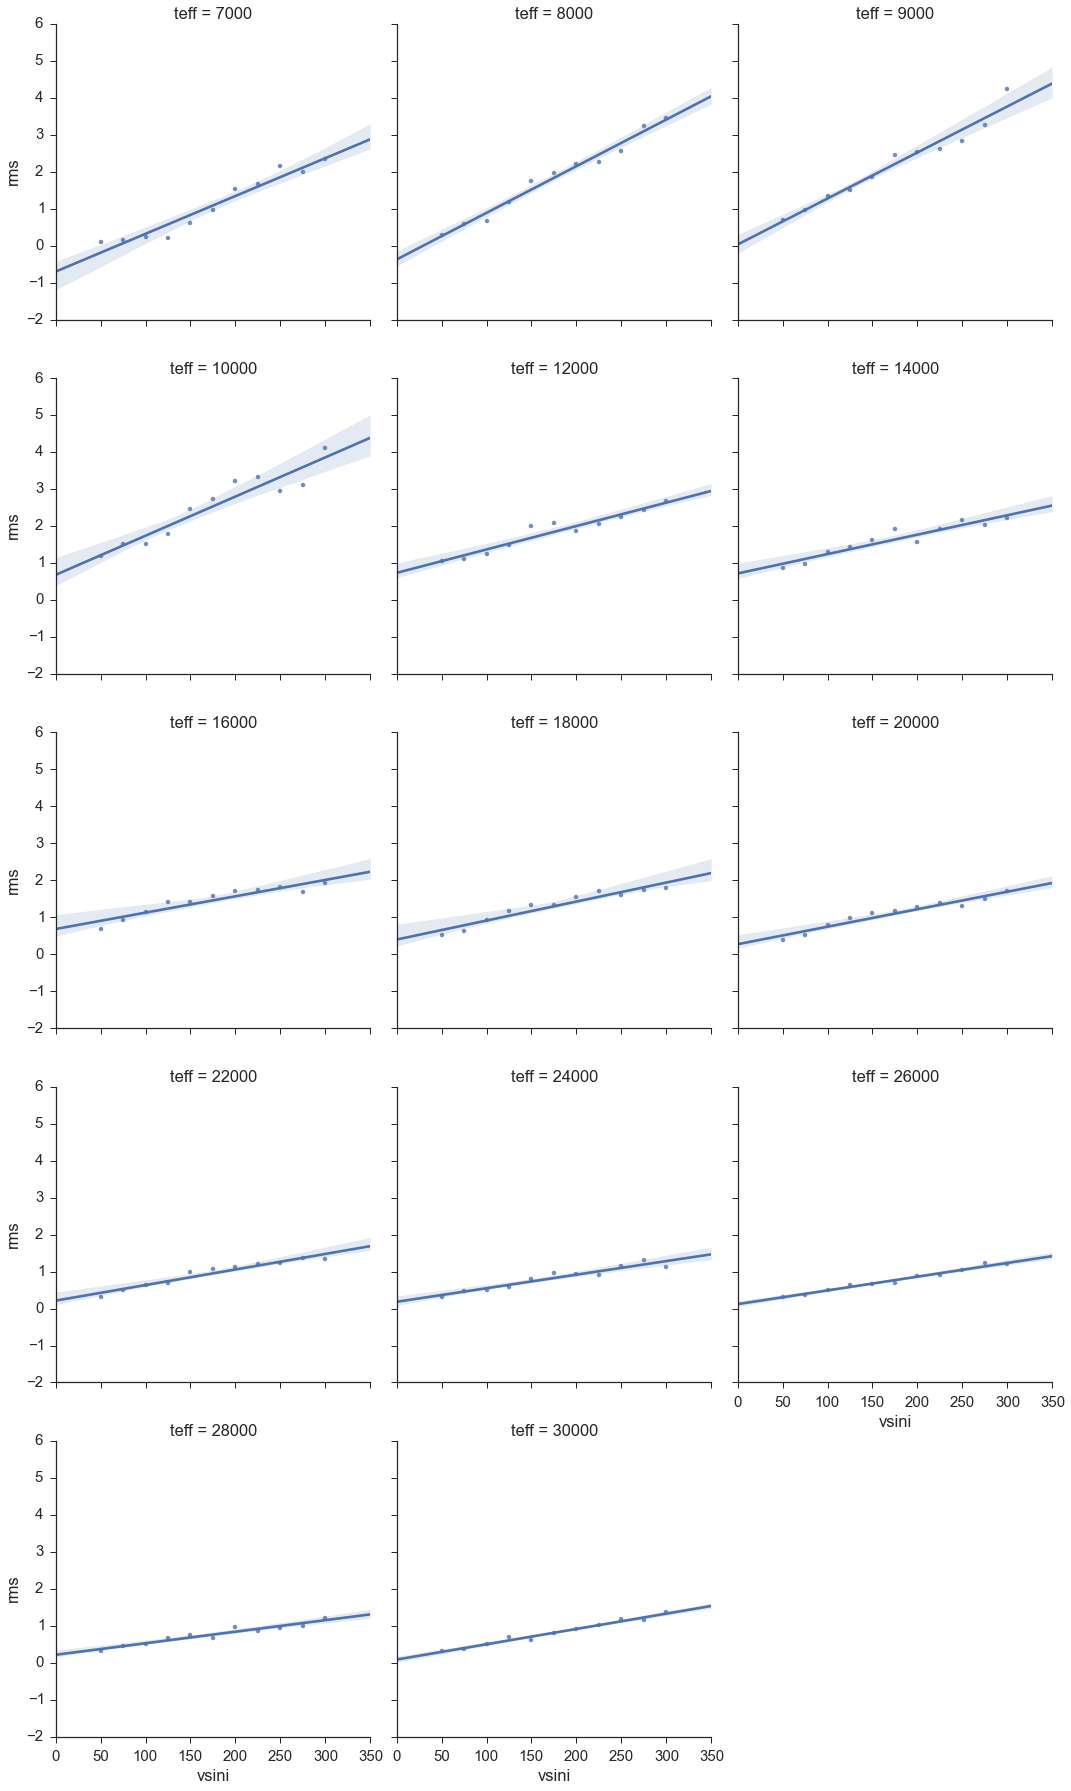

In [52]:
e = error.reset_index()
g = sns.lmplot(x='vsini', y='rms', data=e.loc[e.addmode=='ml'], col='teff', col_wrap=3)

In [49]:
error

rms
teff  vsini addmode          
7000  50    dc       0.121513
            ml       0.104815
            simple   0.126204
      75    dc       0.184406
            ml       0.152206
            simple   0.197745
      100   dc       0.340767
            ml       0.223793
            simple   0.360421
      125   dc       0.452270
            ml       0.210542
            simple   0.472637
      150   dc       0.356814
            ml       0.597935
            simple   0.378434
      175   dc       0.499164
            ml       0.973716
            simple   0.503166
      200   dc       0.831288
            ml       1.521395
            simple   0.743323
      225   dc       1.692142
            ml       1.676870
            simple   1.854363
      250   dc       2.975570
            ml       2.153140
            simple   3.203188
      275   dc       3.276007
            ml       1.994553
            simple   3.226514
...                       ...
30000 75    dc       0.539554
            ml       0.373369
            simple   1.889085
      100   dc       0.624903
            ml       0.501619
            simple   1.783175
      125   dc       0.766394
            ml       0.689176
            simple   1.992179
      150   dc       0.883762
            ml       0.610731
            simple   2.121519
      175   dc       1.105004
            ml       0.813569
            simple   2.424121
      200   dc       1.092242
            ml       0.905141
            simple   2.523254
      225   dc       1.568658
            ml       1.016695
            simple   3.875622
      250   dc       1.408155
            ml       1.181976
            simple   2.937176
      275   dc       1.468633
            ml       1.171460
            simple   3.507985
      300   dc       1.495641
            ml       1.362967
            simple   3.113120

[462 rows x 1 columns]

In [50]:
error.reset_index().to_csv(output_summary_file, index=False)

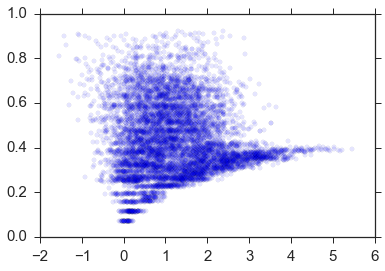

In [55]:
subset = summary.loc[summary.addmode == 'ml']
plt.scatter(subset.rv_err.values, subset.formal_rv_err.values, alpha=0.1)